In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import gym

In [2]:
class PolicyNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, observation):
        return self.network(observation)

/home/elisio/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Number of possible actions: 4
Number of possible states: Box(8,)


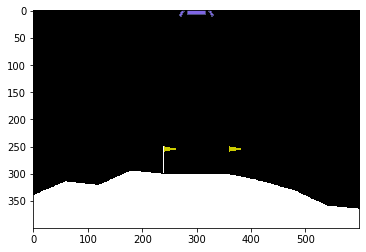

In [3]:
env = gym.make('LunarLander-v2') # make lunar-lander environment

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
policy = PolicyNN(env.observation_space.shape[0], env.action_space.n).to(device)

In [6]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99 #for calculating cumulative rewards
print_rate = 50


optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate) 

In [7]:
# this function receives a list of rewards and returns a list of the calculated cumulative rewards
# of the same size and calculated by the discount factor (gamma)
def get_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rw = []
    for i in reversed(range(len(rewards))):
        rw_sum = 0
        pw = 0 # power to be applied on gamma
        for j in range(i, len(rewards)):
            rw_sum += (gamma**pw)*rewards[j] 
            pw += 1
        cumulative_rw.append(rw_sum)
        
    cumulative_rw.reverse() # reverse the list
    return torch.tensor(cumulative_rw, dtype=torch.float32)

In [8]:
def train(env, gamma, n_episodes=30):
    
    rewards_history = []
    policy_history = []
    
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        rewards_episode = []
        actions_episode = []
        
        while not done:
            state = torch.tensor(state, dtype=torch.float32, device=device)
            action_probs = policy(state)
            
            # sample the distribution of action_probs
            # https://pytorch.org/docs/stable/distributions.html?highlight=distributions#module-torch.distributions
            action = torch.distributions.Categorical(action_probs).sample()
            action = int(action) # convert tensor to int
            
            #print("state:", state)
            #print("action_probs:", action_probs)
            #print("action:", action)
            #l
            
            next_state, reward, done, _ = env.step(action)
            
            rewards_episode.append(reward)
            actions_episode.append(torch.log(action_probs[action])) # store log of action probabilities
            
            state = next_state
        
        rewards_history.append(np.sum(rewards_episode))
        
        if episode % print_rate == 0:
            print("Episode {} \t rewards(mean):{:.4f}".format(episode, np.mean((rewards_history[-print_rate:]))))
            #print("Episode {} \t rewards:{:.4f}".format(episode, np.sum(rewards_episode)))
        
        cumulative_rewards = get_cumulative_rewards(rewards_episode, gamma) # calculate cumulative rewards
        cumulative_rewards = (cumulative_rewards - cumulative_rewards.mean()) / cumulative_rewards.std() # normalization  
        
        objective = 0 # objective function which we want to maximise
        for i in range(len(cumulative_rewards)):
            objective += (-1)*actions_episode[i]*cumulative_rewards[i] # multiplied by -1 for the optimizer to sum the rewards 
            
        objective.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    plt.figure()
    plt.plot(rewards_history)

Episode 0 	 rewards(mean):-68.5939
Episode 50 	 rewards(mean):-183.0258
Episode 100 	 rewards(mean):-145.7881
Episode 150 	 rewards(mean):-140.9572
Episode 200 	 rewards(mean):-96.9704
Episode 250 	 rewards(mean):-82.3826
Episode 300 	 rewards(mean):-64.7146
Episode 350 	 rewards(mean):-97.6995
Episode 400 	 rewards(mean):-28.0983
Episode 450 	 rewards(mean):0.5571
Episode 500 	 rewards(mean):-16.8852
Episode 550 	 rewards(mean):-4.0458
Episode 600 	 rewards(mean):-48.9541
Episode 650 	 rewards(mean):-25.2004
Episode 700 	 rewards(mean):11.1495
Episode 750 	 rewards(mean):61.2582
Episode 800 	 rewards(mean):27.9639
Episode 850 	 rewards(mean):59.9058
Episode 900 	 rewards(mean):67.8046
Episode 950 	 rewards(mean):66.0316
Episode 1000 	 rewards(mean):-23.3347
Episode 1050 	 rewards(mean):-72.0184
Episode 1100 	 rewards(mean):51.2587
Episode 1150 	 rewards(mean):88.3509
Episode 1200 	 rewards(mean):108.4855
Episode 1250 	 rewards(mean):117.2913
Episode 1300 	 rewards(mean):80.3826
Episod

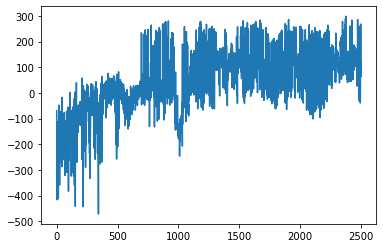

In [9]:
train(env, gamma=0.99, n_episodes=2500)

In [10]:
from time import sleep
for i in range(3):
    state = env.reset()
    done = False
    while not done:
        env.render()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action_probs = policy(state)

        # sample the distribution of action_probs
        # https://pytorch.org/docs/stable/distributions.html?highlight=distributions#module-torch.distributions
        action = torch.distributions.Categorical(action_probs).sample()
        action = int(action) # convert tensor to int

        next_state, reward, done, _ = env.step(action)
        state = next_state
 
        sleep(0.01)